In [24]:
using Plots, PlotThemes, ColorSchemes
using Statistics, Distributions

theme(:juno)
default(fontfamily="times", size=(1200,400), palette=:seaborn_deep6, linewidth=2)

### Filtro de Kalman Escalar

Diseñamos un filtro de Kalman de expresión autoregresiva con ruido de modelo $\eta[n]$
$$s[n] = A s[n-1]+\eta[n] \qquad\qquad \eta[n]\sim\mathcal N (0,\sigma_\eta^2)$$

Para estimar un parámetro $s$ a partir de mediciones $x[n]$ con ruido de medición $\nu[n]$ 
$$x[n]=s[n]+\nu[n]\phantom{A-1} \qquad\qquad \nu[n]\sim\mathcal N(0, \sigma_\nu^2)$$

Realizamos la implementación del algoritmo para un filtro de Kalman en función de los parámetros de varianza $\sigma_\eta^2$ y $\sigma_\nu^2$ y una estimación inicial $s[0]$ con varianza inicial $M[0]$

$$\begin{array}{llcl}
\text{Predicción:}     & s[n|n-1] = As[n-1|n-1]                 & \longrightarrow & \mathtt{s\_est[i]=A*s[i-1]} \\[1em]
\text{ECM predicción:} & M[n|n-1] = A^2M[n-1|n-1]+\sigma^2_\eta & \longrightarrow & \mathtt{M\_est[i]=A^\land 2*M[i-1]+Var\_n}\\[1em]
\text{Ganancia Kalman:} & K[n] = \dfrac{M[n|n-1]}{\sigma^2_\nu+M[n|n-1]} & \longrightarrow & \mathtt{K[i]=M\_est[i]/(Var\_v+M\_est[i]})\\[2em]

\text{Corrección:} & s[n|n] = s[n|n-1]+K[n](x[n]-s[n|n-1]) & \longrightarrow & \mathtt{s[i]=s\_est[i]+K[i]*(x[i]-s\_est[i])}\\[1em]

\text{ECM corrección:} & M[n|n] = (1-K[n])M[n|n-1] & \longrightarrow & \mathtt{M[i]=(1-K[i])*M\_est[i]}\\[1em]
\end{array}
$$

In [25]:
function kalman(x; Var_v, Var_η, A, s0, M0)
    s_est = [A*s0]
    M_est = [A^2*M0+Var_η]
    K = [M_est[1]/(Var_v+M_est[1])]
    s = [s_est[1] + K[1]*(x[1]-s_est[1])]
    M = [(1-K[1])*M_est[1]]

    for i = 2:length(x)
        s_est = [s_est; A*s[i-1]]
        M_est = [M_est; A^2*M[i-1]+Var_η]
        K = [K; M_est[i]/(Var_v+M_est[i])]
        s = [s; s_est[i] + K[i]*(x[i]-s_est[i])]
        M = [M; (1-K[i])*M_est[i]]
    end
    return [s, M, K]
end

kalman (generic function with 1 method)

Usamos el filtro de Kalman para estimar un valor de continua $\theta$ inmerso en ruido, realizando mediciones

$$x[n]=\theta+w[n] \qquad\qquad w[n]\sim\mathcal N(0, \sigma_w^2)$$


In [26]:
x_dist = Normal(10, 1)
x = rand(x_dist, 100);

Para visualizar, graficamos 
- El valor del parámetro a estimar: $\theta$
- La realización de la señal medida: $x[n]$
- La estimación del parámetro: $s[n]$
- El intervalo de confianza de la estimación: $s[n]\pm\sqrt{M[n]}$

In [27]:
function plot_kalman(x, s, θ, M; Var_v, Var_η, A, s0, M0)
    lim = maximum(abs.([extrema(x)..., extrema(s)...]))*1.1
    smin = [s0-sqrt(M0); s.-sqrt.(M)]
    smax = [s0+sqrt(M0); s.+sqrt.(M)]
    vars = [smin, smax]
    p1 = plot(title="A = $A  Var_v = $Var_v  Var_η = $Var_η  s0 = $s0", ylims=(0, lim), legend=:bottomright)
    plot!(p1, [0:length(x)], [s0; s], label="Estimador Kalman")
    plot!(p1, [0:length(x)], vars, linestyle=:dot, color=:teal, label="Intervalo de Confianza")
    plot!(p1, [0:length(x)], [x[end]; x], label="Realización", linewidth=1, linestyle=:dash)
    plot!(p1, [0, length(x)], [θ, θ], label="Parámetro", linestyle=:dashdot, linewidth=1, color=:grey)
end

plot_kalman (generic function with 1 method)

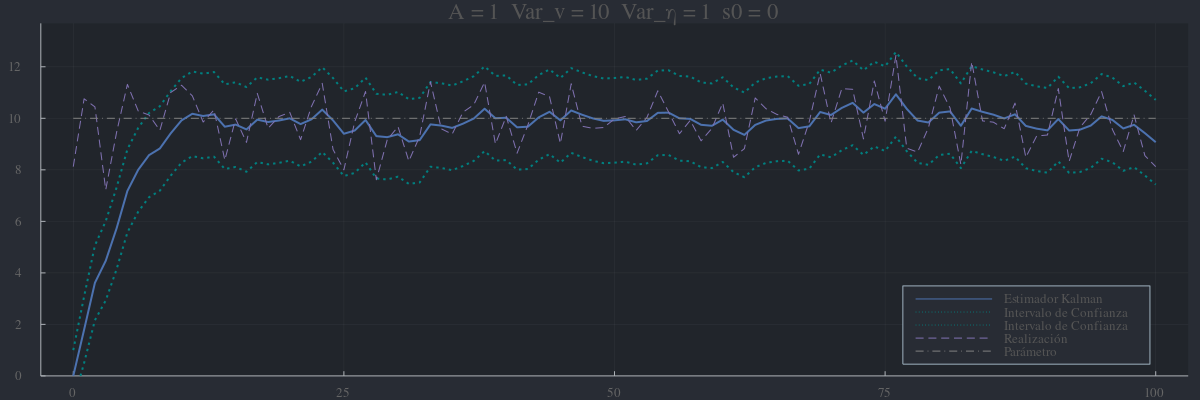

In [28]:
params = (A=1, Var_η=1, Var_v=10, s0=0, M0=1)
    
s, M, K = kalman(x; params...)
plot_kalman(x, s, 10, M; params...)

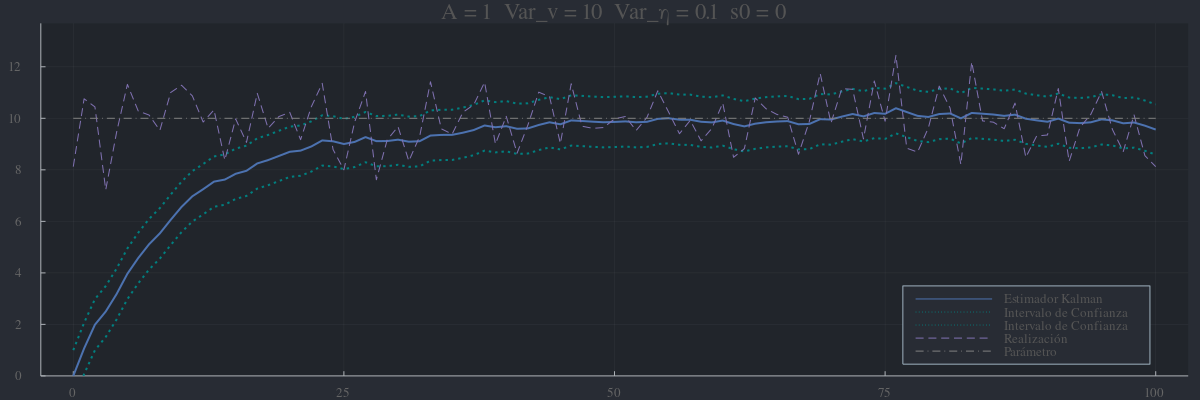

In [29]:
params = (A=1, Var_η=0.1, Var_v=10, s0=0, M0=1)

s, M, K = kalman(x; params...)
plot_kalman(x, s, 10, M; params...)

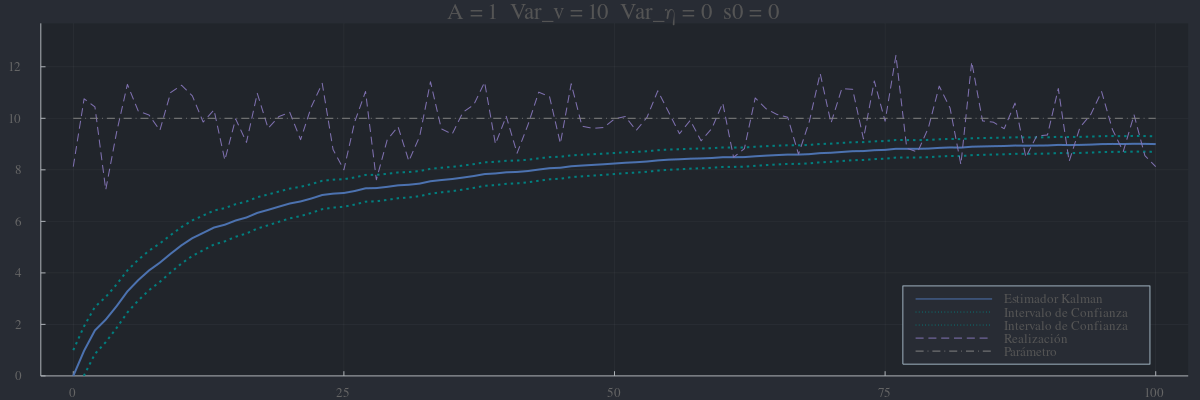

In [30]:
params = (A=1, Var_η=0, Var_v=10, s0=0, M0=1)

s, M, K = kalman(x; params...)
plot_kalman(x, s, 10, M; params...)

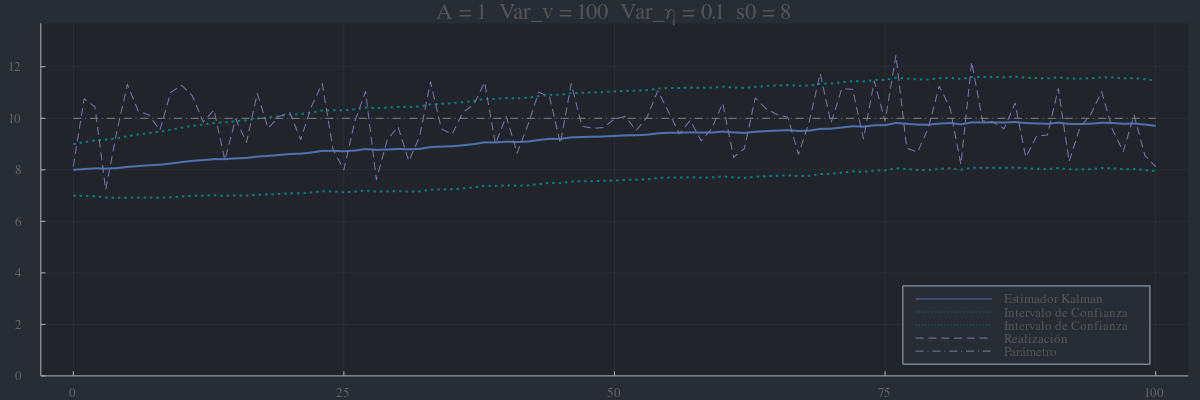

In [31]:
params = (A=1, Var_η=0.1, Var_v=100, s0=8, M0=1)

s, M, K = kalman(x; params...)
plot_kalman(x, s, 10, M; params...)

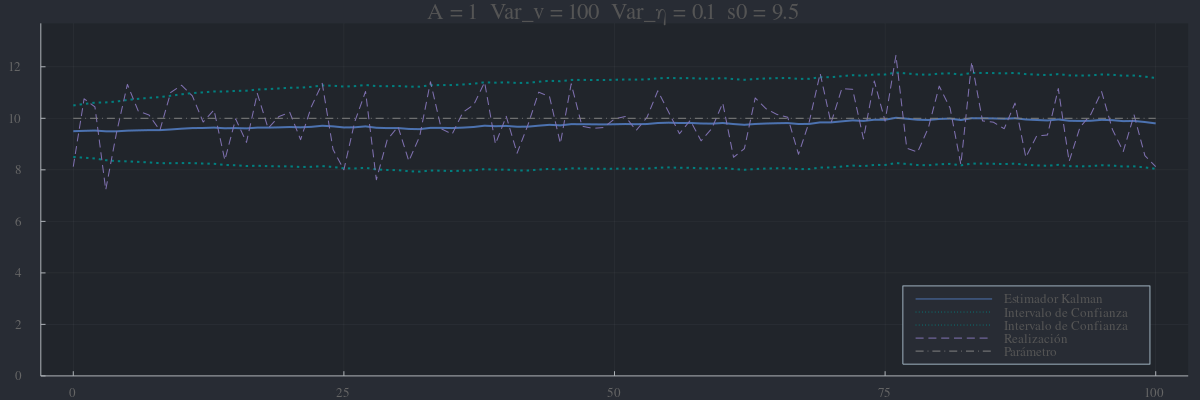

In [32]:
params = (A=1, Var_η=0.1, Var_v=100, s0=9.5, M0=1)

s, M, K = kalman(x; params...)
plot_kalman(x, s, 10, M; params...)

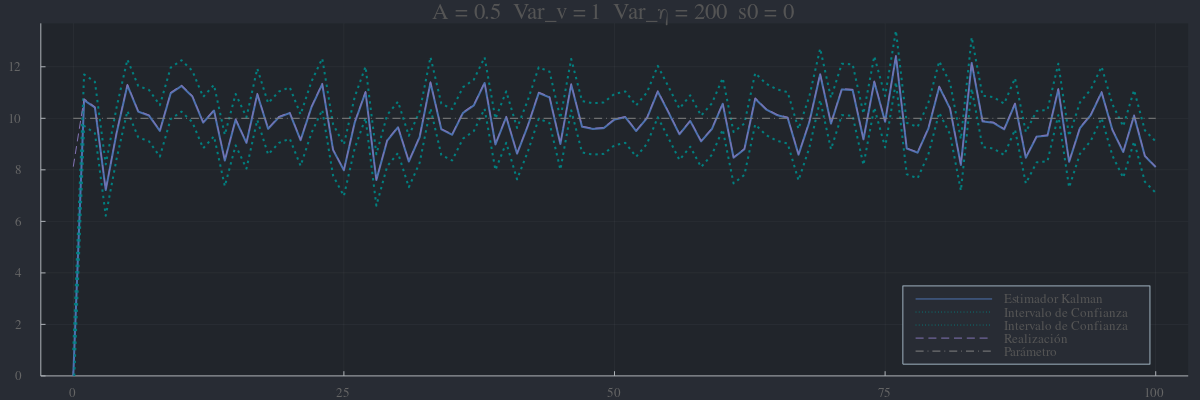

In [33]:
params = (A=0.5, Var_η=200, Var_v=1, s0=0, M0=1)

s, M, K = kalman(x; params...)
plot_kalman(x, s, 10, M; params...)

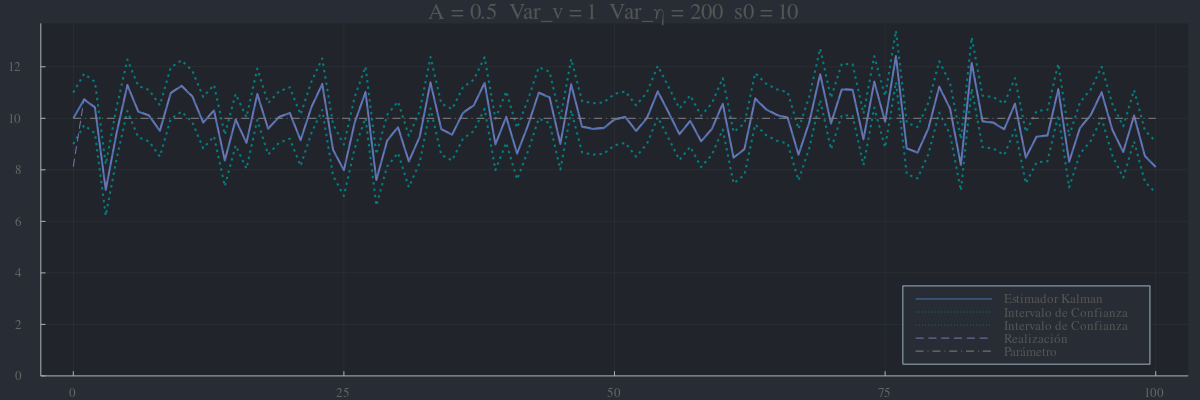

In [34]:
params = (A=0.5, Var_η=200, Var_v=1, s0=10, M0=1)

s, M, K = kalman(x; params...)
plot_kalman(x, s, 10, M; params...)

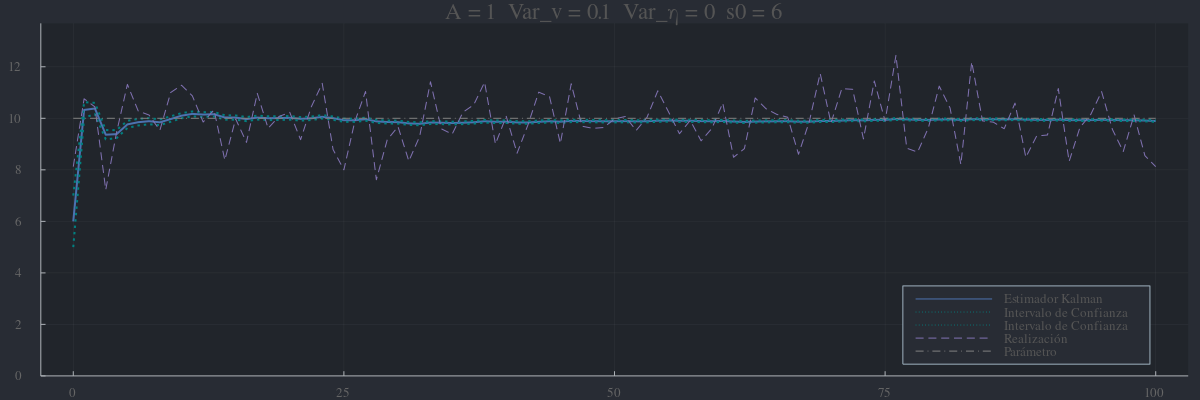

In [35]:
params = (A=1, Var_η=0, Var_v=0.1, s0=6, M0=1)

s, M, K = kalman(x; params...)
plot_kalman(x, s, 10, M; params...)

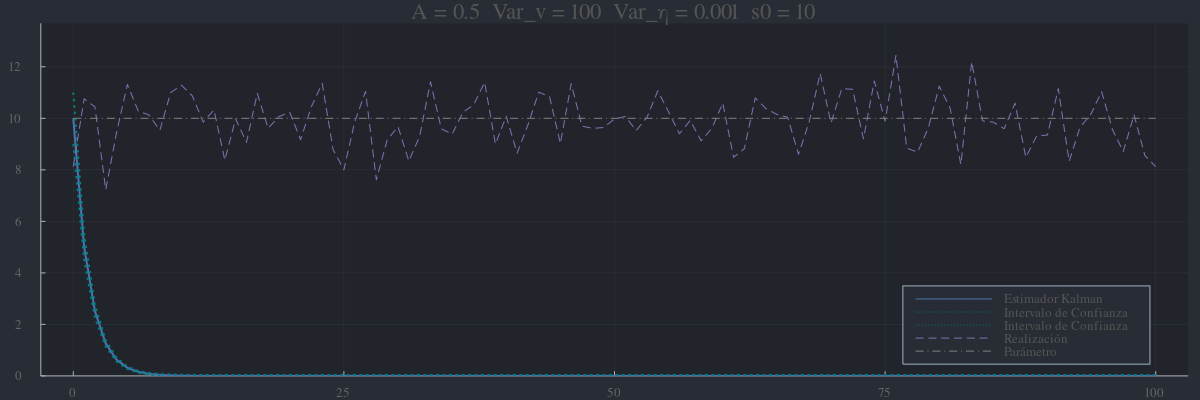

In [36]:
params = (A=0.5, Var_η=0.001, Var_v=100, s0=10, M0=1)

s, M, K = kalman(x; params...)
plot_kalman(x, s, 10, M; params...)

In [37]:
function kalman(x; Var_v, Var_η, A, s0, M0)
    s_est = [A*s0]
    M_est = [A^2*M0+Var_η]
    K = [M_est[1]/(Var_v+M_est[1])]
    s = [s_est[1] + K[1]*(x[1]-s_est[1])]
    M = [(1-K[1])*M_est[1]]

    for i = 2:length(x)
        s_est = [s_est; A*s[i-1]]
        M_est = [M_est; A^2*M[i-1]+Var_η]
        if isnothing(x[i])
            s = [s; s_est[i]]
            M = [M; M_est[i]]
            K = [K; nothing]
        else 
            K = [K; M_est[i]/(Var_v+M_est[i])]
            s = [s; s_est[i] + K[i]*(x[i]-s_est[i])]
            M = [M; (1-K[i])*M_est[i]]
        end
    end
    return [s, M, K]
end

kalman (generic function with 1 method)

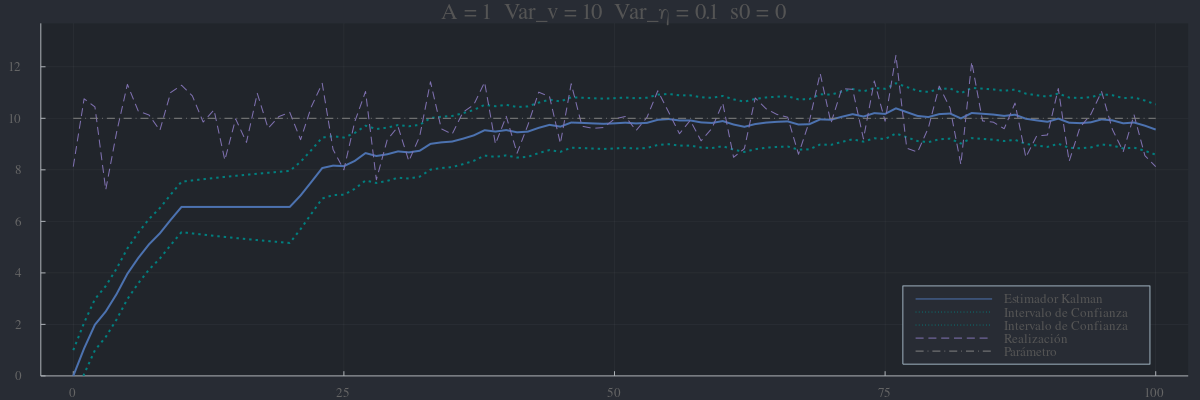

In [38]:
params = (A=1, Var_η=0.1, Var_v=10, s0=0, M0=1)

newx = [[x[i] for i in 1:10]...; [nothing for i in 11:20]...; [x[i] for i in 21:100]...]

s, M, K = kalman(newx; params...)
plot_kalman(x, s, 10, M; params...)

### Aplicación del filtro de Kalman para el cálculo de la derivada

Consideramos el problema de encontrar la derivada de una señal senoidal ruidosa 
$$\tilde s[n] = s[n] + w[n] \qquad \text{con}\qquad \begin{aligned}s[n]&=\sin(6\pi\Delta_T n)\\w[n]&\sim\mathcal N(0, \sigma_w^2)\end{aligned}$$

Observamos el efecto de realizar una derivada numérica por el método habitual de diferencias finitas
$$\tilde s'[n] = \frac{\tilde s[n]-\tilde s[n-1]}{\Delta_T}$$

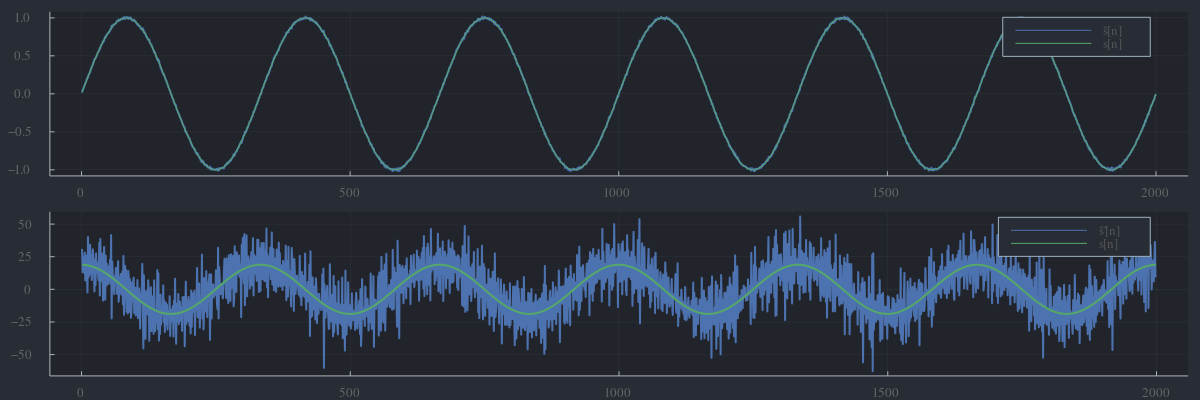

In [39]:
N = 2000
n = 1:N
ΔT = 0.001
s = sin.(6π*n*ΔT)
dsdt = diff(s)./ΔT
s_ruido = s .+ rand(Normal(0, 0.01), N)
dsdt_ruido = diff(s_ruido)./ΔT;

p1 = plot(s_ruido, label="š[n]"); plot!(p1, s, label="s[n]", linewidth=1)
p2 = plot(dsdt_ruido, label="š'[n]"); plot!(p2, dsdt, label="s[n]")
plot(p1,p2,layout=(2,1))

Observamos que incluso si el ruido es chico, afecta significativamente a la derivada. Esto es porque la derivada numérica actúa como filtro pasa alto, amplificando el ruido de alta frecuencia respecto a la frecuencia de la portadora.

Proponemos entonces usar un filtro de Kalman vectorial

$$\begin{aligned}
    \mathbf y[n] &= \mathbf A \mathbf y[n-1] + \mathbf b \eta[n]\\[1em]
    x[n] &= \mathbf h ^ T \mathbf y[n] + \nu[n]
\end{aligned}
    \qquad\text{con}\qquad
\mathbf y [n] = \begin{bmatrix}s[n]\\[0.5em] s'[n]\end{bmatrix} \qquad
x[n] = \tilde s[n] \qquad
\mathbf A = \begin{bmatrix}1&\Delta_T\\ 0&1\end{bmatrix} \qquad
\mathbf b = \begin{bmatrix}0\\1\end{bmatrix} \qquad
\mathbf h = \begin{bmatrix}1\\0\end{bmatrix} \qquad
$$

Explícitamente, el modelo propuesto se reduce a un sistema de tres ecuaciones lineales:

- Un incremento en la señal expresado como diferencia finita 
 $$s[n] = s[n-1]+\Delta_T s'[n-1]$$

- La incerteza del modelo respecto a la derivada de la señal
$$s'[n] = s'[n-1] + \eta[n] $$

- El ruido de medición sobre la señal
$$\tilde s[n] = s[n] + \nu[n]$$

In [40]:
A=[1 ΔT; 0 1]
b=[0; 1]
h=[1; 0];

In [41]:
function kalman_vec(x; Var_v, Var_η, A, b, h, y0, M0)
    K = Vector{Float64}[]
    y = Vector{Float64}[]
    M = Matrix{Float64}[]

    y_est = A*y0
    M_est = A*M0*A'+b*Var_η*b'
    push!(K, M_est*h/(Var_v+h'*M_est*h))
    push!(y, y_est + K[1]*(x[1]-h'y_est))
    push!(M, ([1 0;0 1]-K[1]*h')*M_est)

    for i = 2:length(x)
        y_est = A*y[i-1]
        M_est = A*M[i-1]*A'+b*Var_η*b'
        push!(K, M_est*h/(Var_v+h'*M_est*h))
        push!(y, y_est + K[i]*(x[i]-h'*y_est))
        push!(M, ([1 0;0 1]-K[i]*h')*M_est)
    end
    return [y, M, K]
end

kalman_vec (generic function with 1 method)

In [42]:
function plot_kalman_vec(dsdt, y, M; Var_v, Var_η, A, b, h, y0, M0)
    lim = maximum(abs.([extrema(x)..., extrema(s)...]))*1.1
    dsdt_k = map(last, y) 
    var_k = map(x -> x[2,2], M)
    smin = [y0[2]-sqrt(M0[2,2]); dsdt_k.-sqrt.(var_k)]
    smax = [y0[2]+sqrt(M0[2,2]); dsdt_k.+sqrt.(var_k)]
    vars = [smin, smax]

    p2 = plot(title="Var_v = $Var_v,  Var_η = $Var_η")
    plot!(p2, dsdt); 
    plot!(p2, dsdt_k)
    plot!(p2, vars, linestyle=:dot, color=:teal)
end

plot_kalman_vec (generic function with 1 method)

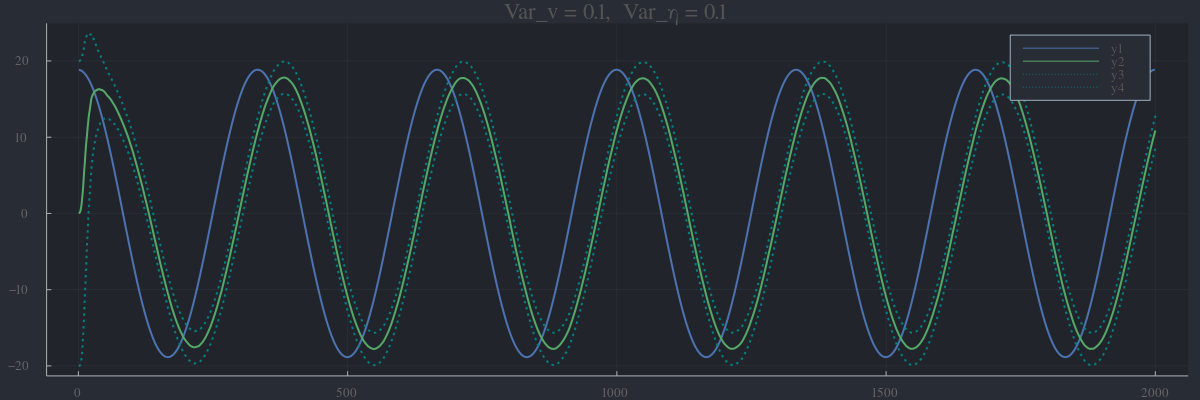

In [83]:
params = (Var_v=0.1, Var_η=0.1, A=A, b=b, h=h, y0=[0; 0], M0=[20^2 0; 0 20^2])
y, M, K = kalman_vec(s_ruido; params...);

plot_kalman_vec(dsdt, y, M; params...)

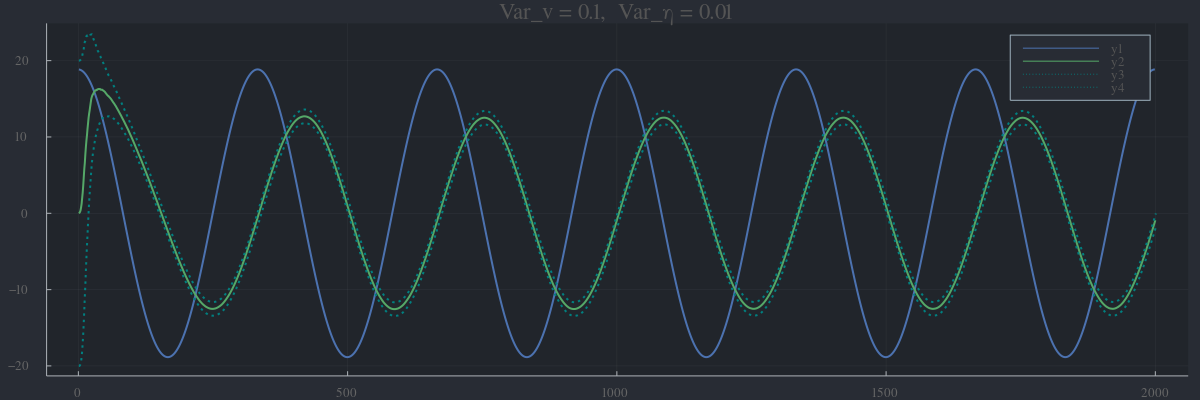

In [81]:
params = (Var_v=0.1, Var_η=0.01, A=A, b=b, h=h, y0=[0; 0], M0=[20^2 0; 0 20^2])
y, M, K = kalman_vec(s_ruido; params...);

plot_kalman_vec(dsdt, y, M; params...)

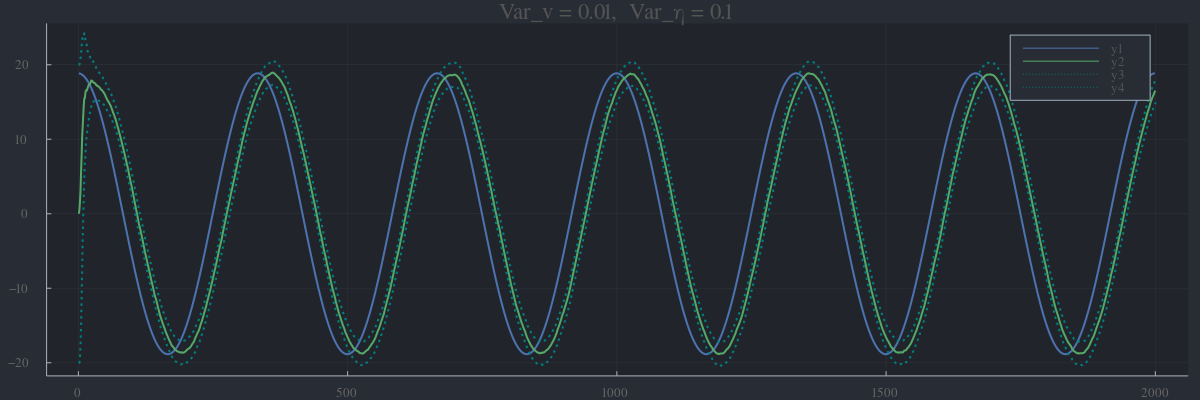

In [82]:
params = (Var_v=0.01, Var_η=0.1, A=A, b=b, h=h, y0=[0; 0], M0=[20^2 0; 0 20^2])
y, M, K = kalman_vec(s_ruido; params...);

plot_kalman_vec(dsdt, y, M; params...)